# Кластеризация. Домашка

## Совсем простая рекомендательная система

На основе оценок аниме, которые ставят пользователи систем типа myanimelist.net
, можно строить разные кластеры данных:
- кластеры похожих людей. Похожие значит, что эти люди ставят похожие рейтинги аниме.
- кластеры похожих аниме. Похожие значит что люди оценивают их похоже.
- кластеры похожих жанров. Но похожие не в обычном смысле, а в смысле, что люди которые смотрят жанр А любят смотреть жанр Б.

и т.д.


In [ ]:
from sklearn import datasets
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tqdm import tqdm
from scipy.special import erfc
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
# from tqdm import tqdm_notebook as tqdm # Раскоментируйте если прогресс бар будет странно работать

%matplotlib inline

np.random.seed(seed=42)

from google.colab import files
uploaded = files.upload()

Saving anime.csv.zip to anime.csv (1).zip


## Анализ отзывов аниме

Возьмем датасет с рейтингами аниме: https://www.kaggle.com/CooperUnion/anime-recommendations-database  
Кстати, вы можете посмотреть kernels - это jupyter notebooks, в которых другие люди тоже делали что-то с этим датасетом.

```
Anime.csv

anime_id - myanimelist.net's unique id identifying an anime.
name - full name of anime.
genre - comma separated list of genres for this anime.
type - movie, TV, OVA, etc.
episodes - how many episodes in this show. (1 if movie).
rating - average rating out of 10 for this anime.
members - number of community members that are in this anime's "group".


Rating.csv

user_id - non identifiable randomly generated user id.
anime_id - the anime that this user has rated.
rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
```

In [ ]:
anime = pd.read_csv('anime.csv.zip', index_col='anime_id')
anime.dropna(inplace=True)
print(anime.shape)
anime.head()

(12017, 6)


,name,genre,type,episodes,rating,members
anime_id,,,,,,
32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [ ]:
from google.colab import files
uploaded = files.upload()
ratings = pd.read_csv('rating.csv.zip')
ratings.head()

Saving rating.csv.zip to rating.csv.zip


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Датасет очень большой и грязный. Некоторые действия с этим датасетом будут требовать много оперативной памяти(>6 Гб).

## Подготовка данных

\Во первых, в датасете есть много -1. Оценки -1 и 0 на myanimelist.net нет.

Здесь -1 означает что человек посмотрел это аниме, но не выставил оценку.

Такие записи из `ratings` стоит выбросить, так как в нашем случае они особо не помогут.

Но и не помешают серьезно. Если хотите оставьте их, только нужно заменить все -1 на 0, так как дальше нам понадобится посчитать среднее, а -1 или 0, в отличие от `np.nan`, повлияют на среднее.

### 1. Избавьтесь от -1

In [ ]:
print(f"Размер исходного датасета: {ratings.shape}")
ratings_cleaned = ratings[ratings['rating'] != -1]
print(f"Размер очищенного датасета: {ratings_cleaned.shape}")
print(ratings_cleaned.head())
ratings_cleaned.to_csv("cleaned_ratings.csv", index=False)
print("Очищенный датасет сохранен в файл 'cleaned_ratings.csv'")

Размер исходного датасета: (7813737, 3)
Размер очищенного датасета: (6337241, 3)
     user_id  anime_id  rating
47         1      8074      10
81         1     11617      10
83         1     11757      10
101        1     15451      10
153        2     11771      10
Очищенный датасет сохранен в файл 'cleaned_ratings.csv'


## Критерий Шавене (Chauvenet)

[Теория](https://www.youtube.com/watch?v=Fy9pHH3ykPE&list=PLLyuiBK_HOLPfRVN6r9305FKXq1ravbbX)

$$ \operatorname{erfc}(\frac{|P_i - mean(P)|}{S_p})  < \frac{1}{2n}$$

$ S_p - отклонение $

Готовой реализации в библиотеках нет, поэтому придется написать самим(но если найдете можете использовать).

`erfc` — это дополнительная функция ошибок Гаусса. [wiki](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA)

$$\operatorname{erfc}\,x = 1-\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}} \int\limits_x^{\infty} e^{-t^2}\,\mathrm dt$$

$$\operatorname{erf}\,x = \frac{2}{\sqrt{\pi}}\int\limits_0^x e^{-t^2}\,\mathrm dt$$

### 2. Напишите функцию, которая принимает на вход массив, считает критерий Шавене и возвращает булеву маску.

Функция `erfc` есть в sklearn.

In [ ]:
def chauvenet(array):
    n = len(array)
    mean = np.mean(array)
    std_dev = np.std(array)
    criterion = erfc(np.abs(array - mean) / (std_dev * np.sqrt(2)))
    mask = criterion >= 1 / (2 * n)
    return mask


example_array = np.array([10, 12, 13, 12, 500, 11, 10])
mask = chauvenet(example_array)

print("Массив значений:", example_array)
print("Булева маска:", mask)
print("Значения, проходящие критерий:", example_array[mask])


Массив значений: [ 10  12  13  12 500  11  10]
Булева маска: [ True  True  True  True False  True  True]
Значения, проходящие критерий: [10 12 13 12 11 10]


Для начала давайте посмотрим на таблицу рейтингов.

### 3. Сделайте новую таблицу `count_reviews` где индексами будет `user_id` а значением будет количество просмотренных им аниме.


**Hint** Используйте [groupby](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html) и [count](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.count.html).

In [ ]:
count_reviews = ratings_cleaned.groupby('user_id')['anime_id'].count()
count_reviews = count_reviews.reset_index()
count_reviews.columns = ['user_id', 'count_reviews']
print(count_reviews.head())


   user_id  count_reviews
0        1              4
1        2              1
2        3             92
3        5            459
4        7            343


### 4. Используйте функцию chauvenet и найдите все выбросы.

**Hint:** Так как chauvenet возвращает маску используйте оператор `[]` (подробнее смотрите в 1 теории по pandas и numpy).

**Hint:** Используйте [values](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html).

In [ ]:
mask = chauvenet(count_reviews['count_reviews'].values)
outlier_users = count_reviews[~mask]
print(f"Количество выбросов: {len(outlier_users)}")
print("Примеры выбросов:")
print(outlier_users.head())


Количество выбросов: 550
Примеры выбросов:
      user_id  count_reviews
214       226            742
419       446            743
446       478            863
900       958            783
1077     1145            904


### 5. Ответьте на вопросы

#### Кого критерий посчитал выбросом?
Критерий Шавене посчитал выбросами пользователей, у которых количество просмотренных аниме значительно превышает типичные значения для большинства. Эти пользователи имеют значения, которые отклоняются от среднего на несколько стандартных отклонений и встречаются крайне редко.

#### Почему критерий посчитал их выбросом?
Эти пользователи статистически выделяются, так как их количество просмотренных аниме значительно превышает среднее значение в выборке. Такие значения имеют низкую вероятность появления в рамках нормального распределения.

#### Нужна ли им вообще рекомендательная система?
Вероятно посмотрев столько тайтлов они уже и сами неплохо разбираются в теме, поэтому маловероятно.

### 6. Переименнуйте столбец из таблицы count_reviews в count_reviews (он там единственный). Соедините count_reviews и ratings по столбцу user_id. И оставьте в ratings только тех кто посмотрел меньше bad_user_threshold





In [ ]:
bad_user_threshold = outlier_users.min()
bad_user_threshold

,0
user_id,226
count_reviews,701


In [ ]:
bad_user_threshold = outlier_users['count_reviews'].min()
count_reviews.rename(columns={'count_reviews': 'count_reviews'}, inplace=True)
ratings_merged = ratings_cleaned.merge(count_reviews, on='user_id', how='inner')
ratings_filtered = ratings_merged[ratings_merged['count_reviews'] < bad_user_threshold]
print(f"Размер отфильтрованного датасета: {ratings_filtered.shape}")
print(ratings_filtered.head())


Размер отфильтрованного датасета: (5804470, 4)
   user_id  anime_id  rating  count_reviews
0        1      8074      10              4
1        1     11617      10              4
2        1     11757      10              4
3        1     15451      10              4
4        2     11771      10              1


Осталось все равно слишком много пользователей.

### 7. Удалите из таблицы всех юзеров, у которых количество просмотров меньше медианного значения. То есть мы удалим половину юзеров.

Так как они посмотрели слишком мало, чтобы мы на них могли основывать свои советы.

In [ ]:
median_reviews = ratings_filtered['count_reviews'].median()
print(f"Среднее количество просмотренных тайтлов: {median_reviews}")
ratings_median_filtered = ratings_filtered[ratings_filtered['count_reviews'] >= median_reviews]
ratings_final = ratings_median_filtered.drop(columns=['count_reviews'])
print(f"Размер датасета после фильтрации: {ratings_final.shape}")
print(ratings_final.head())

Среднее количество просмотренных тайтлов: 180.0
Размер датасета после фильтрации: (2914542, 3)
     user_id  anime_id  rating
97         5         6       8
98         5        15       6
99         5        17       6
100        5        18       6
101        5        20       6


Теперь рассмотрим таблицу `anime`.


Так же применим критерий шавене.

Искать выбросы стоит по столбцу `rating` или по `members` или по обоим сразу.

### 8. Используйте функцию chauvenet и найдите все выбросы среди аниме. И удалите их.

**Hint** Используйте [drop](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html) и [index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.index.html)

In [ ]:
mask_rating = chauvenet(anime['rating'].values)
mask_members = chauvenet(anime['members'].values)
combined_mask = mask_rating & mask_members
outlier_anime_indices = anime[~combined_mask].index
anime_cleaned = anime.drop(index=outlier_anime_indices)
print(f"Размер исходной таблицы: {anime.shape}")
print(f"Размер таблицы после удаления выбросов: {anime_cleaned.shape}")


Размер исходной таблицы: (12017, 6)
Размер таблицы после удаления выбросов: (11867, 6)


### 9. Ответье на вопросы

#### Что критерий посчитал выбросом?
Критерий Шавене посчитал выбросами те аниме, которые имеют аномально высокие или низкие значения по столбцам rating или members. Такие значения статистически отклоняются от среднего распределения данных.

#### Почему критерий посчитал их выбросом?
Эти аниме выбиваются из общего распределения из-за:
Слишком высокой или слишком низкой популярности.
Чрезмерно высоких или низких оценок по сравнению с большинством аниме.

#### Можем ли мы как то использовать эти аниме в нашей рекомендательное системе?
 Аниме с необычно высокими рейтингами можно использовать для создания подборок ("лучшее из лучших").
 Аниме с высоким количеством участников могут подойти для рекомендаций новым пользователям, которые только начинают знакомство с жанром.

## Кластеризация по жанрам

### 10. Создадим новую таблицу, где в колонках будет жанр, в строках аниме, а в ячейках 1 если у фильма есть этот жанр и 0 в противном случае.

Такой формат таблиц называтеся one-hot-encoding. Только в нашем случае в каждой строке будет не одна единица, а несколько, так как у аниме как правило несолько жанров.

Уточнение: жанры должны быть индексами столбцов (columns), а id аниме - индексами строк (index)

In [ ]:
def flatmap(f, items):
    return chain.from_iterable(map(f, items))

def genre_splitter(genre_names):
    return genre_names.split(", ")

m_uniq = anime['genre'].unique()
print(f"Уникальные жанры: {m_uniq[:5]}")
unique_genres = set(flatmap(genre_splitter, m_uniq))
print(f"Всего уникальных жанров: {len(unique_genres)}")
genres = list(unique_genres)
genre_matrix = pd.DataFrame(0, index=anime.index, columns=genres)

for idx, row in anime.iterrows():
    if pd.notna(row['genre']):
        for genre in genre_splitter(row['genre']):
            genre_matrix.at[idx, genre] = 1

genre_matrix.index = anime.index
print(genre_matrix.head())


Пример уникальных комбинаций жанров: ['Drama, Romance, School, Supernatural'
 'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen'
 'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen'
 'Sci-Fi, Thriller' 'Comedy, Drama, School, Shounen, Sports']
Всего уникальных жанров: 43
          Psychological  Horror  Sports  Music  Demons  Yaoi  Drama  Magic  \
anime_id                                                                     
32281                 0       0       0      0       0     0      1      0   
5114                  0       0       0      0       0     0      1      1   
28977                 0       0       0      0       0     0      0      0   
9253                  0       0       0      0       0     0      0      0   
9969                  0       0       0      0       0     0      0      0   

          Mecha  Yuri  ...  Romance  School  Shoujo  Comedy  Hentai  Military  \
anime_id               ...                                                    

Итак, у нас есть следующие таблицы:
- Жанры аниме - в строчках аниме, в столбцах жанр аниме, а в ячейках 0 или 1.
- Рейтинги - в строчках пользователи, в столбцах id аниме и рейтинг

Нужно получить другую таблицу, в которой в строках будут пользователи, а в столбцах жанры аниме. А в ячейках средняя оценка жанра этим пользователем.

Средняя оценка жанра вычисляется следующим образом: берём все отзывы пользователя. Группируем все его отзывы по жанрам и считаем средний рейтинг, который он ставит аниме с данным жанром.

Выполним следущие шаги.

### 11. Соединим две таблицы:<br>
1. жанры по каждому аниме<br>
2. оценки аниме от людей. Кстати, один человек мог посмотреть 1 аниме или 100, но не все!<br>

Получим таблицу, где строк будет N*M штук, где N - количество юзеров и M - количество аниме

In [ ]:
ratings_cleaned = ratings[ratings['rating'] != -1]
ratings_with_genres = ratings_cleaned.merge(genre_matrix, left_on='anime_id', right_index=True, how='inner')

for genre in genre_matrix.columns:
    ratings_with_genres[genre] = ratings_with_genres['rating'] * ratings_with_genres[genre]

user_genre_matrix = ratings_with_genres.groupby('user_id')[genre_matrix.columns].mean()
user_genre_matrix = user_genre_matrix.round(1)
print("Итоговая таблица:")
print(user_genre_matrix.head(5))

Итоговая таблица (пример данных):
         Psychological  Horror  Sports  Music  Demons  Yaoi  Drama  Magic  \
user_id                                                                     
1                  0.0     2.5     0.0    0.0     5.0   0.0    0.0    0.0   
2                  0.0     0.0    10.0    0.0     0.0   0.0    0.0    0.0   
3                  0.8     0.6     0.9    0.0     0.3   0.0    2.5    1.2   
5                  0.1     0.1     0.5    0.1     0.2   0.0    0.9    0.3   
7                  0.6     0.2     0.3    0.1     0.5   0.0    1.1    0.9   

         Mecha  Yuri  ...  Romance  School  Shoujo  Comedy  Hentai  Military  \
user_id               ...                                                      
1          0.0   0.0  ...      7.5     5.0     0.0     5.0     0.0       0.0   
2          0.0   0.0  ...      0.0    10.0     0.0    10.0     0.0       0.0   
3          0.1   0.0  ...      0.7     1.1     0.1     3.2     0.0       0.3   
5          0.0   0.0  ... 

С такой таблицей `(N*M) * G` мы всё еще не можем работать.  
### 12. Сгруппируем строки по пользователям (колонка `userId`).  В группах посчитаем среднюю оценку на жанр. А если пользователь не смотрел фильм, то поставим ему `-1` в соответсвующую ячейку.
Чтобы посчитать среднее(mean) без учета непросмотренных аниме замените все `0` на `np.NaN`

In [ ]:
user_genre_matrix = user_genre_matrix.replace(0, np.NaN)
print("После замены 0 на NaN:")
print(user_genre_matrix.head())
user_genre_matrix_mean = user_genre_matrix.mean()


После замены 0 на NaN:
         Psychological  Horror  Sports  Music  Demons  Yaoi  Drama  Magic  \
user_id                                                                     
1                  NaN     2.5     NaN    NaN     5.0   NaN    NaN    NaN   
2                  NaN     NaN    10.0    NaN     NaN   NaN    NaN    NaN   
3                  0.8     0.6     0.9    NaN     0.3   NaN    2.5    1.2   
5                  0.1     0.1     0.5    0.1     0.2   NaN    0.9    0.3   
7                  0.6     0.2     0.3    0.1     0.5   NaN    1.1    0.9   

         Mecha  Yuri  ...  Romance  School  Shoujo  Comedy  Hentai  Military  \
user_id               ...                                                      
1          NaN   NaN  ...      7.5     5.0     NaN     5.0     NaN       NaN   
2          NaN   NaN  ...      NaN    10.0     NaN    10.0     NaN       NaN   
3          0.1   NaN  ...      0.7     1.1     0.1     3.2     NaN       0.3   
5          NaN   NaN  ...      1.0   

Так как некоторые пользователи не смотрели ничего из некоторых жанров, в данных осталось много `np.NaN`
### 13. Заполните все NaN на -1

**Hint** [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html)

In [ ]:
user_genre_matrix_filled = user_genre_matrix.fillna(-1)
print("После заполнения NaN значениями -1:")
print(user_genre_matrix_filled.head())

После заполнения NaN значениями -1:
         Psychological  Horror  Sports  Music  Demons  Yaoi  Drama  Magic  \
user_id                                                                     
1                 -1.0     2.5    -1.0   -1.0     5.0  -1.0   -1.0   -1.0   
2                 -1.0    -1.0    10.0   -1.0    -1.0  -1.0   -1.0   -1.0   
3                  0.8     0.6     0.9   -1.0     0.3  -1.0    2.5    1.2   
5                  0.1     0.1     0.5    0.1     0.2  -1.0    0.9    0.3   
7                  0.6     0.2     0.3    0.1     0.5  -1.0    1.1    0.9   

         Mecha  Yuri  ...  Romance  School  Shoujo  Comedy  Hentai  Military  \
user_id               ...                                                      
1         -1.0  -1.0  ...      7.5     5.0    -1.0     5.0    -1.0      -1.0   
2         -1.0  -1.0  ...     -1.0    10.0    -1.0    10.0    -1.0      -1.0   
3          0.1  -1.0  ...      0.7     1.1     0.1     3.2    -1.0       0.3   
5         -1.0  -1.0  ..

Прежде чем начать обучать kMeans...

### 14. Отмасштабируйте признаки.

Как мы знаем по лекции, метрическим алгоритмам, одним из которых и является kMeans, лучше подавать на вход данные одного масштаба.  Этим и занимается метод MinMaxScaler из sklearn.

[Документация](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

Алгоритм его работы:
```
X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
X_scaled = X_std * (max - min) + min
```

In [ ]:
scaler = MinMaxScaler()
user_genre_matrix_scaled = pd.DataFrame(
    scaler.fit_transform(user_genre_matrix_filled),
    columns=user_genre_matrix_filled.columns,
    index=user_genre_matrix_filled.index
)
print("Масштабированние данных:")
print(user_genre_matrix_scaled.head())

Пример масштабированных данных:
         Psychological    Horror    Sports  Music    Demons  Yaoi     Drama  \
user_id                                                                       
1             0.000000  0.318182  0.000000    0.0  0.545455   0.0  0.000000   
2             0.000000  0.000000  1.000000    0.0  0.000000   0.0  0.000000   
3             0.163636  0.145455  0.172727    0.0  0.118182   0.0  0.318182   
5             0.100000  0.100000  0.136364    0.1  0.109091   0.0  0.172727   
7             0.145455  0.109091  0.118182    0.1  0.136364   0.0  0.190909   

            Magic     Mecha  Yuri  ...   Romance    School    Shoujo  \
user_id                            ...                                 
1        0.000000  0.000000   0.0  ...  0.772727  0.545455  0.000000   
2        0.000000  0.000000   0.0  ...  0.000000  1.000000  0.000000   
3        0.200000  0.100000   0.0  ...  0.154545  0.190909  0.100000   
5        0.118182  0.000000   0.0  ...  0.181818  0.19

### 15.Натренируйте kMeans с 10 кластерами на полученных данных

In [ ]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(user_genre_matrix_scaled)
user_clusters = kmeans.predict(user_genre_matrix_scaled)
user_genre_matrix_scaled['cluster'] = user_clusters
print("Данные с кластеризацией:")
print(user_genre_matrix_scaled.head())


Пример данных с кластеризацией:
         Psychological    Horror    Sports  Music    Demons  Yaoi     Drama  \
user_id                                                                       
1             0.000000  0.318182  0.000000    0.0  0.545455   0.0  0.000000   
2             0.000000  0.000000  1.000000    0.0  0.000000   0.0  0.000000   
3             0.163636  0.145455  0.172727    0.0  0.118182   0.0  0.318182   
5             0.100000  0.100000  0.136364    0.1  0.109091   0.0  0.172727   
7             0.145455  0.109091  0.118182    0.1  0.136364   0.0  0.190909   

            Magic     Mecha  Yuri  ...    School    Shoujo    Comedy  Hentai  \
user_id                            ...                                         
1        0.000000  0.000000   0.0  ...  0.545455  0.000000  0.545455     0.0   
2        0.000000  0.000000   0.0  ...  1.000000  0.000000  1.000000     0.0   
3        0.200000  0.100000   0.0  ...  0.190909  0.100000  0.381818     0.0   
5        0.118

### 16. Нарисуйте на графике центры кластеров нашего датасета оценок фильмов.

В нем будет 10 строчек - 10 кластеров. И 43 столбцов - 43 жанров фильмов.

Из графика мы поймем какие жанры обычно смотрят вместе. По сути мы получили кластеры предпочтений людей.

**Hint** [Heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

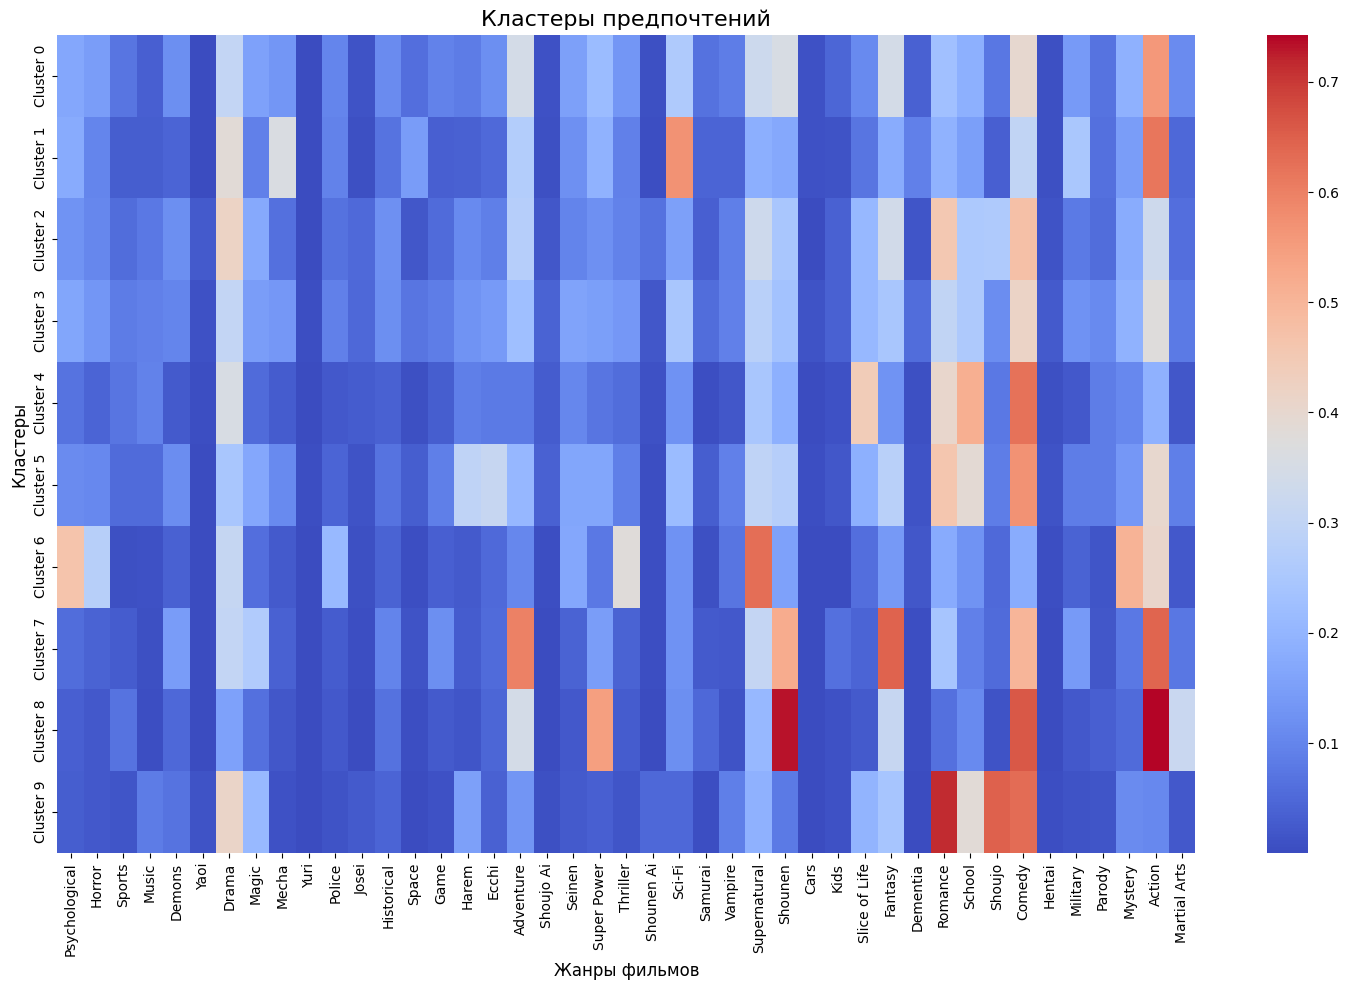

In [ ]:
cluster_centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=user_genre_matrix_scaled.columns[:-1]
)

plt.figure(figsize=(15, 10))

sns.heatmap(cluster_centers, annot=False, cmap="coolwarm", xticklabels=True, yticklabels=[f"Cluster {i}" for i in range(10)])

plt.title("Кластеры предпочтений", fontsize=16)
plt.xlabel("Жанры аниме", fontsize=12)
plt.ylabel("Кластеры", fontsize=12)
plt.tight_layout()
plt.show()


# Как выбрать нужное число кластеров

Такие методы как KMeans, Spectral clustering, Ward hierarchical clustering, Agglomerative clustering требуют количество кластеров как параметр. Это так называемый гипер-параметр, и его должен подбирать человек. Но на что человеку опираться при выборе? На некоторый функционал "качества"!

Вспомним идею кластеризации:
- минимизация внутрикластерного расстояния
- максимизация межкластерного расстояния

Другими словами - кучки кучнее и дальше друг от друга.

Логично, что мы хотим, чтобы точки распологались кучно возле центров своих кластеров. Но вот незадача: минимум такого функционала будет достигаться тогда, когда кластеров столько же, сколько и точек (то есть каждая точка – это кластер из одного элемента). Для решения этого вопроса (выбора числа кластеров) часто пользуются такой эвристикой: выбирают то число кластеров, начиная с которого описанный функционал $ J(C) $ падает "уже не так быстро". Или более формально: $$ D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Где, в случае kMeans $$ J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$ - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

#### Эта ячейка может выполнятся долго!

In [ ]:
inertia = []
N = 30
for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k).fit(scaler.fit_transform(df))
    inertia.append(np.sqrt(kmeans.inertia_))
plt.figure(figsize=(10,7))
plt.plot(range(1, N), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

## Коэффициент силуэта

Данный коэффициент не предполагает знания истинных меток объектов, и позволяет оценить качество кластеризации, используя только саму (неразмеченную) выборку и результат кластеризации.

Сначала силуэт определяется отдельно для каждого объекта. Обозначим через $a$ - среднее расстояние от данного объекта до объектов из того же кластера, через $b$ - среднее расстояние от данного объекта до объектов из ближайшего кластера (отличного от того, в котором лежит сам объект). Тогда силуэтом данного объекта называется величина: $$s = \frac{b - a}{\max(a, b)}.$$ Силуэтом выборки называется средняя величина силуэта объектов данной выборки. Таким образом, силуэт показывает, насколько среднее расстояние до объектов своего кластера отличается от среднего расстояния до объектов других кластеров. Данная величина лежит в диапазоне $[-1, 1]$. Значения, близкие к -1, соответствуют плохим (разрозненным) кластеризациям, значения, близкие к нулю, говорят о том, что кластеры пересекаются и накладываются друг на друга, значения, близкие к 1, соответствуют "плотным" четко выделенным кластерам. Таким образом, чем больше силуэт, тем более четко выделены кластеры, и они представляют собой компактные, плотно сгруппированные облака точек.

С помощью силуэта можно выбирать оптимальное число кластеров $k$ (если оно заранее неизвестно) - выбирается число кластеров, максимизирующее значение силуэта. В отличие от предыдущих метрик, силуэт зависит от формы кластеров, и достигает больших значений на более выпуклых кластерах, получаемых с помощью алгоритмов, основанных на восстановлении плотности распределения.

#### Эта ячейка может выполняться долго!

In [ ]:
def draw_sil_score(X, range_n_clusters=[2, 3, 4, 5, 6, 10, 12, 13, 20]):
    scores = []
    for n_clusters in tqdm(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = silhouette_score(X, cluster_labels)
        scores.append(silhouette_avg)
    plt.plot(range_n_clusters, scores)
    return range_n_clusters[np.argmax(scores)]

In [ ]:
draw_sil_score(scaler.fit_transform(df), range(2, 30))

### 17. Выберите количество кластеров `k` по методам выше. Натренируйте kMeans и снова нарисуйте heatmap.

100%|██████████| 29/29 [00:17<00:00,  1.61it/s]


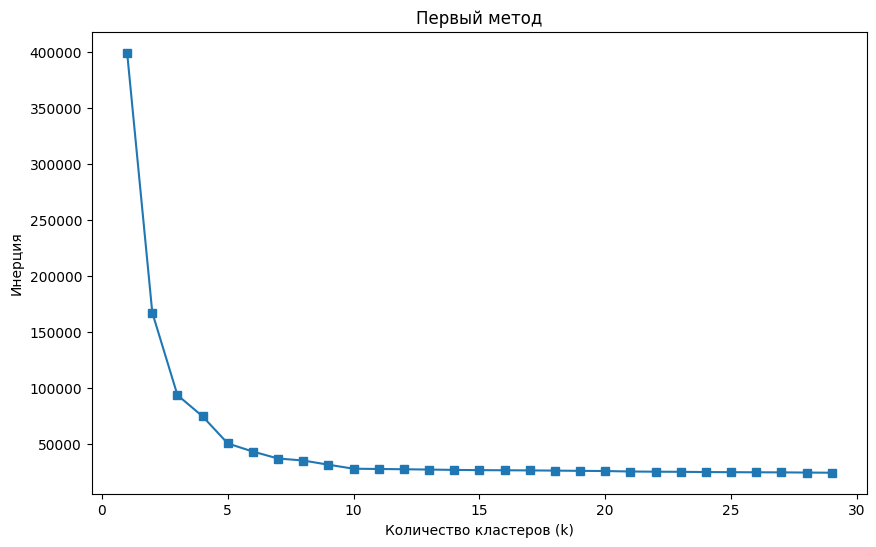

In [ ]:
N = 30
inertia = []

for k in tqdm(range(1, N)):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_genre_matrix_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, N), inertia, marker='s')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Инерция")
plt.title("Первый метод")
plt.show()


100%|██████████| 29/29 [32:06<00:00, 66.43s/it]


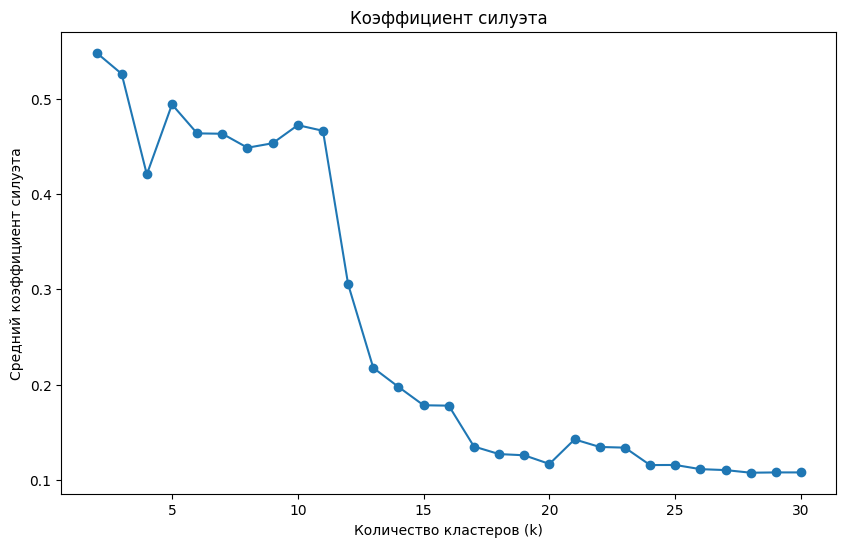

Оптимальное количество кластеров: 2


In [ ]:
range_n_clusters = range(2, 31)
silhouette_scores = []

for n_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(user_genre_matrix_scaled)
    silhouette_avg = silhouette_score(user_genre_matrix_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Средний коэффициент силуэта")
plt.title("Коэффициент силуэта")
plt.show()

optimal_k = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Оптимальное количество кластеров: {optimal_k}")


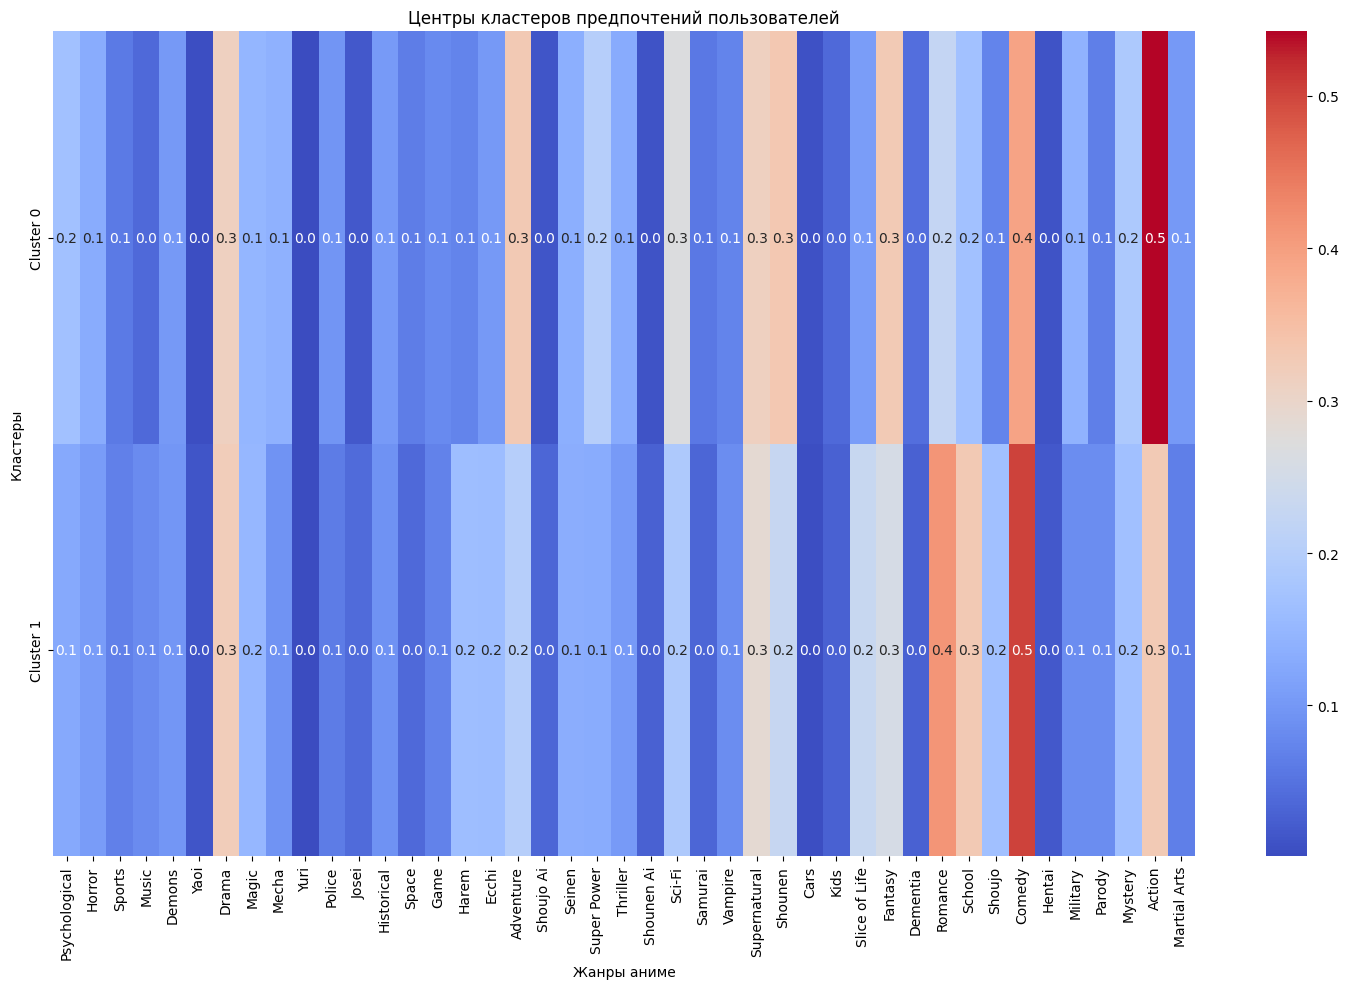

In [ ]:
if 'cluster' in user_genre_matrix_scaled.columns:
    user_genre_matrix_scaled = user_genre_matrix_scaled.drop(columns=['cluster'])

kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_optimal.fit(user_genre_matrix_scaled)

optimal_cluster_centers = pd.DataFrame(
    kmeans_optimal.cluster_centers_,
    columns=user_genre_matrix_scaled.columns
)

plt.figure(figsize=(15, 10))
sns.heatmap(
    optimal_cluster_centers,
    annot=True,
    fmt=".1f",
    cmap="coolwarm",
    xticklabels=True,
    yticklabels=[f"Cluster {i}" for i in range(optimal_k)]
)

plt.title("Центры кластеров предпочтений пользователей")
plt.xlabel("Жанры аниме")
plt.ylabel("Кластеры")
plt.tight_layout()
plt.show()


### 18. Порекомендуйте что-нибудь абстрактному пользователю.
Это можно сделать разными способами. Как это сделать подумайте сами.

Если затрудняетесь реализовать это в коде, распишите словами как вы бы это сделали.

Возможные варианты решения:
 * в каждом кластере отсортировать жанры по тому, насколько жанр важен.
 * взять каждый кластер -> получить все аниме, которые смотрят в этом кластере -> отсортировать по рейтину.



In [ ]:
1)Для каждого кластера определяются наиболее важные жанры
Например, если пользователь принадлежит кластеру, где "Action" и "Comedy" имеют высокие значения, то можно рекомендовать больше аниме этих жанров.

2)Из всех аниме, которые чаще всего смотрят пользователи данного кластера, выбираются те, которые имеют самые высокие рейтинги.
Это будет подход "рекомендации популярных аниме среди схожих пользователей".